# Solar Radiation Monitoring Laboratory (SRML)

The [Solar Radiation Monitoring Laboratory (SRML)](http://solardata.uoregon.edu/index.html) at the University of Oregon has been providing [solar radiation data](http://solardata.uoregon.edu/SolarData.html) for the Northeastern United States since 1975. The SRML monitoring station network consists of both high-quality stations (Tier 1) that measure all three irradiance components at a 1-minute resolution, as well as stations with low-quality instruments (Tier 2) that only log measurements hourly. A full list of the 42 stations (including discontinued stations) can be found at the [SRML website](http://solardata.uoregon.edu/MonitoringStations.html).

Only the high-quality SRML stations are included in the SolarStations' [station catalog](../station_catalog); however, all active stations are shown below.


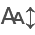

In [1]:
import pandas as pd
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

stations = pd.read_csv('station_network_srml.csv').fillna('')
stations = stations[stations['Network'].str.contains('SRML')]
del stations['URL']  # Remove the URL column to avoid cluttering the site

show(stations, scrollY="500px", scrollX=True, scrollCollapse=True, paging=False, classes="display", order=[[0, "asc"]],
     showIndex=False, columnDefs=[{"className": "dt-left", "targets": "_all"}])

In [4]:
import folium
from folium import plugins
import folium_legend

EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
EsriAttribution = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"

# Create Folium map
m = folium.Map(
    location=[45, -118],
    zoom_start=5, min_zoom=3, max_bounds=True,
    control_scale=True,  # Adds distance scale in lower left corner
    tiles='openstreetmap',
)

# Add each station to the map
# Consider using apply instead of for loop to add stations in case of many stations
for index, row in stations.iterrows():
    if row['Tier'] == 1:  # Tier 1 stations (high-quality)
        color = 'purple'
    else:
        color = 'orange'  # Tier 2 stations
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['Station full name'] + ' - ' + str(row['State']) + ' ' + row['Country'],
        tooltip=row['Abbreviation'],
        radius=9, color=color,
        fill_color=color, fill=True).add_to(m)

folium.raster_layers.TileLayer(EsriImagery, name='World imagery', attr=EsriAttribution, show=False).add_to(m)
folium.LayerControl(position='topleft').add_to(m)

# Additional options and plugins
# Note it's not possible to change the position of the scale
plugins.MiniMap(toggle_display=True, zoom_level_fixed=2, minimized=True, position='bottomright').add_to(m)  # Add minimap to the map
plugins.Fullscreen(position='topright').add_to(m)  # Add full screen button to map
folium.LatLngPopup().add_to(m)  # Show latitude/longitude when clicking on the map
# plugins.LocateControl(position='topright').add_to(m)  # Add button for your position
# plugins.MeasureControl(position='topleft').add_to(m)  # Add distance length measurement tool

# Create legend
labels = ['Tier 1', 'Tier 2']
colors = ['purple', 'orange']  # copied from above
legend = folium_legend.make_legend(labels, colors, title="Station quality")
m.get_root().html.add_child(legend)  # Add Legend to map

# Show the map
m

## Data retrieval

Data from the SRML stations are stored in monthly files for each station and can be freely [downloaded](http://solardata.uoregon.edu/SelectArchivalUpdatedFormat.html) from their website. The data can also be downloaded programmatically using the [pvlib-python](https://pvlib-python.readthedocs.io) library, specifically the [`pvlib.iotools.get_srml`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_srml.html) function. A list of the station acronyms can be found [here](http://solardata.uoregon.edu/StationIDCodes.html).

```{admonition} Help support the SRML
If you find the data useful, please consider donating to [support the SRML](http://solardata.uoregon.edu/Donate.html).
```

An example of how to use pvlib to download data from the [Hermiston station](http://solardata.uoregon.edu/Hermiston.html) for June 2020 is shown here:

In [3]:
import pvlib

df, meta = pvlib.iotools.get_srml(
    station='HE',
    start='2020-06-01',
    end='2020-06-30',
    url='http://solardata.uoregon.edu/download/Archive/')

# print the first 12 rows of data
show(df.head(), scrollX=True, scrollCollapse=True, paging=False, maxColumns=100, dom="tpr")

C:\Users\arajen\Anaconda3\envs\solarstations\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


```{margin} Available parameters
Click the "Click to show" button to see the first 12 data entries.
```

The data retrieved from the Hermiston station include measurements of the three irradiance components and additional weather parameters including temperature and humidity. A few of the parameters in the downloaded datasets are visualized below.

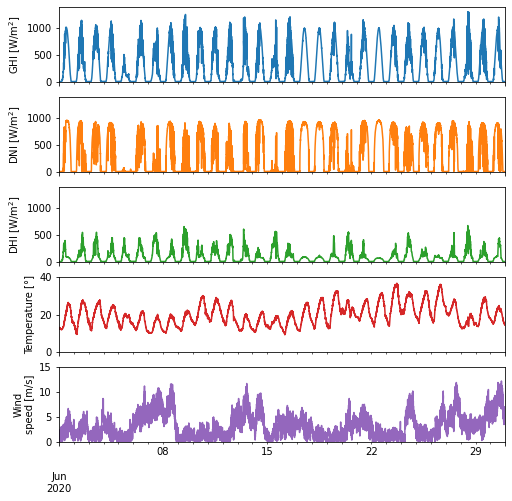

In [4]:
axes = df[['ghi_0','dni_0','dhi_3','temp_air_1','wind_speed_1']].plot(
    subplots=True, legend=False, rot=0, figsize=(8,8), sharex=True)

# Set y-labels and y-limits
axes[0].set_ylabel('GHI [W/m$^2$]'), axes[0].set_ylim(-10,1400)
axes[1].set_ylabel('DNI [W/m$^2$]'), axes[1].set_ylim(-10,1400)
axes[2].set_ylabel('DHI [W/m$^2$]'), axes[2].set_ylim(-10,1400)
axes[3].set_ylabel('Temperature [°]'), axes[3].set_ylim(0,40)
_ = axes[4].set_ylabel('Wind\nspeed [m/s]'), axes[4].set_ylim(0,15)